# 1) Install and import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install transformers
!pip install  datasets evaluate seqeval
!pip install onnx onnxruntime onnxconverter-common
!pip install optimum

import onnx
import os
import json
import numpy as np
import torch
from datasets import load_dataset
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    MobileBertForTokenClassification
)
import matplotlib.pyplot as plt
import onnxruntime
from pathlib import Path
from optimum.exporters.tasks import TasksManager
from optimum.exporters.onnx import export as onnx_export
from onnxruntime.quantization import quantize_dynamic
from onnxconverter_common import float16
from onnxruntime.quantization import (
    quantize_static,
    QuantFormat,
    QuantType,
    CalibrationDataReader
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.6 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=c4cff9725edf24dcaf3cbe7f5b28593dbadd71ab1259a136e8046b7dc505bf27
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.6/433.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 744.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

# 2) Configurations & Setup

In [3]:
model_checkpoint = "google/mobilebert-uncased"             # 95 MB
# model_checkpoint = "distilbert/distilbert-base-uncased"   # 253 MB
# model_checkpoint = 'microsoft/MiniLM-L12-H384-uncased'    # 127 MB
# model_checkpoint = 'prajjwal1/bert-tiny'                  # 17 MB

num_epochs = 25
batch_size = 16
learning_rate = 0.00005

# Define labels
entity_labels = ["HOSP", "PERSON", "STAFF","PHONE", "ID", "EMAIL", "LOC", "ORG", "AGE", "BIRTHDATE", "DATE", "TIMESTAMPS", "URL"]
all_labels = ["O"] + entity_labels
label2id = {label: i for i, label in enumerate(all_labels)}
id2label = {i: label for label, i in label2id.items()}

print("Labels:", all_labels)

# Disable W&B if don't want to log there - no need for now (optional)
os.environ["WANDB_DISABLED"] = "true"

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

Labels: ['O', 'HOSP', 'PERSON', 'STAFF', 'PHONE', 'ID', 'EMAIL', 'LOC', 'ORG', 'AGE', 'BIRTHDATE', 'DATE', 'TIMESTAMPS', 'URL']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# 3) Load the dataset

In [4]:
data_files = {
    "train": "train.json",
    "validation": "validation.json"
}

raw_dataset = load_dataset("json", data_files=data_files)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

# 4) Alignment function to map entity spans to token labels

In [5]:
def align_spans_to_tokens(examples):
    texts = examples["sentence"]
    batch_tokenized = tokenizer(
        texts,
        truncation=True,
        return_offsets_mapping=True
    )

    new_labels = []
    for i, offsets in enumerate(batch_tokenized["offset_mapping"]):
        spans = examples["spans"][i]
        span_entities = [(s["start"], s["end"], s["label"]) for s in spans]

        token_labels = ["O"] * len(offsets)

        for span_start, span_end, span_label in span_entities:
            for idx, (token_start, token_end) in enumerate(offsets):
                # Ignore special token offsets, typically (0, 0)
                if token_start == 0 and token_end == 0:
                    continue
                # If there's overlap, assign label
                if token_end > span_start and token_start < span_end:
                    token_labels[idx] = span_label

        label_ids = [label2id[label] for label in token_labels]
        new_labels.append(label_ids)

    batch_tokenized["labels"] = new_labels
    # We don't need offsets once we've created labels
    batch_tokenized.pop("offset_mapping")
    return batch_tokenized

# 5) Apply the alignment to create encoded dataset

In [6]:
encoded_dataset = raw_dataset.map(
    align_spans_to_tokens,
    batched=True,
    remove_columns=raw_dataset["train"].column_names
)

train_dataset = encoded_dataset["train"]
eval_dataset = encoded_dataset["validation"]

Map:   0%|          | 0/1197 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/211 [00:00<?, ? examples/s]

# 6) Load model and move to device (if cuda available)

In [8]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(all_labels),
    id2label=id2label,
    label2id=label2id
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using device:", device)

# Create data collator for token classification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

Some weights of MobileBertForTokenClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


# 7) Set up evaluation metric (seqeval)

In [9]:
metric = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = []
    true_predictions = []

    for label_ids, pred_ids in zip(labels, predictions):
        # Filter out ignored indices if any (e.g., -100)
        filtered_labels = []
        filtered_preds = []
        for l, p_ in zip(label_ids, pred_ids):
            if l != -100:
                filtered_labels.append(id2label[l])
                filtered_preds.append(id2label[p_])

        true_labels.append(filtered_labels)
        true_predictions.append(filtered_preds)

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }


# 8) Define training arguments

In [10]:
training_args = TrainingArguments(
    output_dir="./mobilebert-finetuned-ner",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",        # <-- epoch/steps
    logging_steps=20,                # <-- step frequency
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,     # 16-32
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,          # 5-10 (start with 8)
    weight_decay=0.01,
    warmup_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


# 9) Create Trainer and start training

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

# Evaluate the final model
metrics = trainer.evaluate()
print("Evaluation metrics:", metrics)

# Save final model & tokenizer
trainer.save_model("fine_tuned_model")
tokenizer.save_pretrained("fine_tuned_model")

<ipython-input-14-36b1bfc364d6>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.185400,0.872065,0.191781,0.168067,0.179143,0.768589
2,0.367400,0.204110,0.644989,0.726291,0.683230,0.936718
3,0.090100,0.074133,0.886705,0.920768,0.903416,0.979577
4,0.060900,0.061260,0.940688,0.951981,0.946301,0.984755
5,0.043800,0.054037,0.951422,0.963986,0.957662,0.986768
6,0.029600,0.056025,0.943662,0.965186,0.954303,0.985905
7,0.026900,0.059181,0.957041,0.962785,0.959904,0.988350
8,0.017400,0.051650,0.966306,0.963986,0.965144,0.987631
9,0.006200,0.057647,0.972323,0.969988,0.971154,0.988063
10,0.006400,0.046676,0.975990,0.975990,0.975990,0.990508


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: LOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PERSON seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ORG seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BIRTHDATE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: STAFF seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: LOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PERSON seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ORG seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BIRTHDATE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: STAFF seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.

Evaluation metrics: {'eval_loss': 0.04667627438902855, 'eval_precision': 0.9759903961584634, 'eval_recall': 0.9759903961584634, 'eval_f1': 0.9759903961584634, 'eval_accuracy': 0.9905076945203509, 'eval_runtime': 1.2287, 'eval_samples_per_second': 171.72, 'eval_steps_per_second': 11.394, 'epoch': 13.0}


('fine_tuned_model/tokenizer_config.json',
 'fine_tuned_model/special_tokens_map.json',
 'fine_tuned_model/vocab.txt',
 'fine_tuned_model/added_tokens.json',
 'fine_tuned_model/tokenizer.json')

# 10) Save the final model & tokenizer

In [16]:
output_dir = "/content/drive/MyDrive/models/model 14 | 2024-03-07"

trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)


('/content/drive/MyDrive/models/model 14 | 2024-03-07/tokenizer_config.json',
 '/content/drive/MyDrive/models/model 14 | 2024-03-07/special_tokens_map.json',
 '/content/drive/MyDrive/models/model 14 | 2024-03-07/vocab.txt',
 '/content/drive/MyDrive/models/model 14 | 2024-03-07/added_tokens.json',
 '/content/drive/MyDrive/models/model 14 | 2024-03-07/tokenizer.json')

# Plot graphs

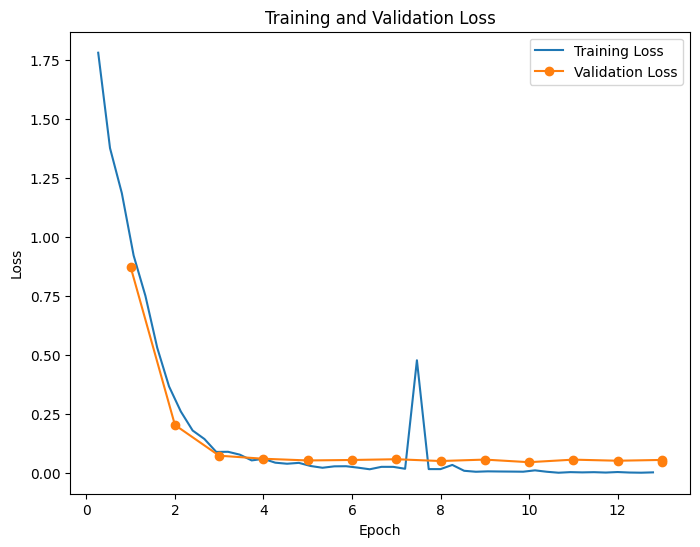

<Figure size 640x480 with 0 Axes>

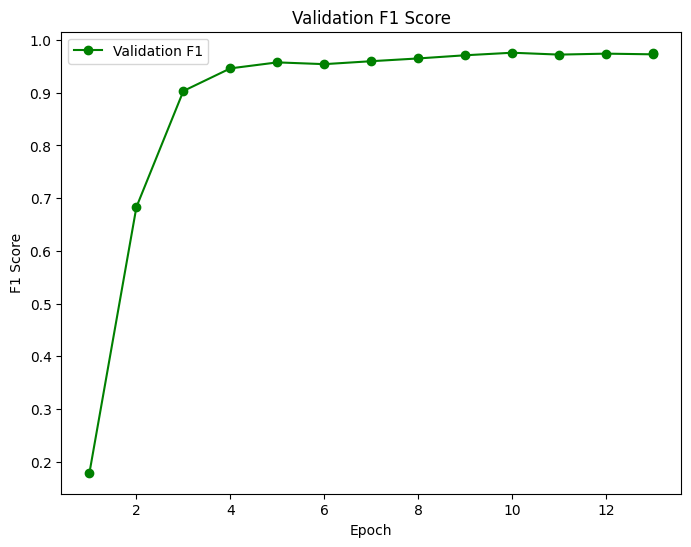

<Figure size 640x480 with 0 Axes>

In [17]:
# Extract the log history
log_history = trainer.state.log_history

# 1) Plot Training vs. Validation Loss
train_loss_vals = []
train_epochs = []
eval_loss_vals = []
eval_epochs = []

for entry in log_history:
    # Training loss entries
    if "loss" in entry and "epoch" in entry:
        train_loss_vals.append(entry["loss"])
        train_epochs.append(entry["epoch"])
    # Evaluation loss entries
    if "eval_loss" in entry and "epoch" in entry:
        eval_loss_vals.append(entry["eval_loss"])
        eval_epochs.append(entry["epoch"])

plt.figure(figsize=(8, 6))
plt.plot(train_epochs, train_loss_vals, label="Training Loss")
plt.plot(eval_epochs, eval_loss_vals, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()
plt.savefig( output_dir + "/Training and Validation Loss.png")

# 2) Plot F1 Score over time
eval_f1_vals = []
eval_f1_epochs = []

for entry in log_history:
    if "eval_f1" in entry and "epoch" in entry:
        eval_f1_vals.append(entry["eval_f1"])
        eval_f1_epochs.append(entry["epoch"])

plt.figure(figsize=(8, 6))
plt.plot(eval_f1_epochs, eval_f1_vals, label="Validation F1", marker='o', color='green')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Score")
plt.legend()
plt.show()
plt.savefig( output_dir + "/eval_f1_vals.png")


# 11) Inference / Testing the Trained Model (Optional)

In [18]:
# Example input text
test_text = """Immunization Report
Patient Name: Sandamali Herath
Patient ID: 6269540V
Date of Birth: March 15, 2010
Report ID: IMMU7890
Physician Name: Dr.Hemal Senanayake
Date of Report: April 10, 2024

Immunization Record
Vaccine Name	Date Administered	Dose	Site of Administration	Administered By
Hepatitis B	January 20, 2021	0.5 mL	Left Deltoid	Nurse Kamala Selvaraj
Influenza (Flu)	October 5, 2023	0.5 mL	Right Arm	Nurse Nuthara Pathirana
Measles-Mumps-Rubella	April 15, 2021	0.5 mL	Left Thigh	Dr.Hemal Senanayake
Tetanus (Tdap)	June 10, 2022	0.5 mL	Left Deltoid	Nurse Kamala Selvaraj
COVID-19 (Pfizer)	May 12, 2023	0.3 mL	Right Deltoid	Nurse Nuthara Pathirana
Notes
Upcoming Vaccines: HPV vaccine scheduled for June 2024.
Adverse Reactions: None reported for any administered vaccines.
Clinic Information:
Kalubowila Main Hospital
No 1, Kalubowila Hospital, Kalubowila, Colombo
Contact: (+94)6281110123
"""

In [19]:
# Load the trained model and tokenizer
model_path = "fine_tuned_model"
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
model = AutoModelForTokenClassification.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

id2label = model.config.id2label  # Should already be stored in config

# Tokenize
inputs = tokenizer(test_text, return_tensors="pt", truncation=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Get predictions
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
predictions = torch.argmax(logits, dim=2).cpu().numpy()[0]

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].cpu().numpy()[0])

# Print token and predicted label
for token, pred_id in zip(tokens, predictions):
    label = id2label[pred_id]
    # Skip special tokens
    if token not in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
        print(f"{token}\t{label}")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


im	O
##mun	O
##ization	O
report	O
patient	O
name	O
:	O
sand	PERSON
##ama	PERSON
##li	PERSON
her	PERSON
##ath	PERSON
patient	O
id	O
:	O
62	ID
##6	ID
##9	ID
##54	ID
##0	ID
##v	ID
date	O
of	O
birth	O
:	O
march	BIRTHDATE
15	BIRTHDATE
,	BIRTHDATE
2010	BIRTHDATE
report	O
id	O
:	O
im	ID
##mu	ID
##7	ID
##8	ID
##90	ID
physician	O
name	O
:	O
dr	STAFF
.	STAFF
hem	STAFF
##al	STAFF
sen	STAFF
##ana	STAFF
##ya	STAFF
##ke	STAFF
date	O
of	O
report	O
:	O
april	DATE
10	DATE
,	DATE
202	DATE
##4	DATE
im	O
##mun	O
##ization	O
record	O
vaccine	O
name	O
date	O
administered	O
dose	O
site	O
of	O
administration	O
administered	O
by	O
hepatitis	O
b	O
january	DATE
20	DATE
,	DATE
2021	DATE
0	O
.	O
5	O
ml	O
left	O
del	O
##to	O
##id	O
nurse	STAFF
kamal	STAFF
##a	STAFF
se	STAFF
##lva	STAFF
##raj	STAFF
influenza	O
(	O
flu	O
)	O
october	DATE
5	DATE
,	DATE
202	DATE
##3	DATE
0	O
.	O
5	O
ml	O
right	O
arm	O
nurse	STAFF
nut	STAFF
##hara	STAFF
path	STAFF
##ira	STAFF
##na	STAFF
me	O
##as	O
##les	O
-	O
mum	O
##ps	O
-	O
rub	O
##e

# Convrt to ONNX and Save ONNX model

In [20]:
onnx_config_constructor = TasksManager.get_exporter_config_constructor(
    model=model,                # Trained model
    task="token-classification", # The task name
    exporter="onnx"             # Exporter type
)

onnx_config = onnx_config_constructor(model.config)

# (Optional) Adjust opset or other config settings if needed
# onnx_config.dynamic_axes = {
#     "input_ids": {0: "batch_size", 1: "sequence_length"},
#     "attention_mask": {0: "batch_size", 1: "sequence_length"}
# }

# Export the model
onnx_path = Path(output_dir+"/model.onnx")
model.cpu()
onnx_export(
    model=model,
    config=onnx_config,
    opset=12,         # or whichever opset version you want
    output=onnx_path, # Save to this file
    device="cpu"      # Typically "cpu" for export, but can be "cuda" if you prefer
)

print(f"ONNX model has been saved to {onnx_path}")


Passing the argument `library_name` to `get_supported_tasks_for_model_type` is required, but got library_name=None. Defaulting to `transformers`. An error will be raised in a future version of Optimum if `library_name` is not provided.
/usr/local/lib/python3.11/dist-packages/transformers/models/mobilebert/modeling_mobilebert.py:547: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  torch.tensor(1000),
/usr/local/lib/python3.11/dist-packages/torch/onnx/_internal/jit_utils.py:308: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:178.)
  _C._jit_pass_onnx_node_shape_type_inference(node, 

ONNX model has been saved to /content/drive/MyDrive/models/model 14 | 2024-03-07/model.onnx


# Test onnx model (Optional)

In [24]:
onnx_model_path = output_dir+"/model.onnx"

# Load the tokenizer from saved "fine_tuned_model" directory
# tokenizer = AutoTokenizer.from_pretrained("fine_tuned_model", use_fast=True)    # already loaded before

# Create an ONNX Runtime session
ort_session = onnxruntime.InferenceSession(onnx_model_path)

# Tokenize the text
encoded_inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True
)

# Convert to numpy for ONNX
# (input_ids, attention_mask, and token_type_ids if they exist)
inputs_onnx = {k: v.cpu().numpy() for k, v in encoded_inputs.items()}

# Run inference
outputs = ort_session.run(None, inputs_onnx)
# ONNX export for TokenClassification will produce a single output:
# logits of shape (batch_size, sequence_length, num_labels)
logits = outputs[0]

# Take the argmax to get predicted label IDs
predictions_onnx = np.argmax(logits, axis=2)[0]  # shape: (sequence_length,)

# Convert IDs back to tokens
tokens = tokenizer.convert_ids_to_tokens(encoded_inputs["input_ids"][0])


def printresults():
    print(f"Token\t|\tlabel_py_t\t|\tlabel_onnx")
    print("-"*50)
    for token, pred_id, pred_id_onnx in zip(tokens, predictions, predictions_onnx):
        label = id2label[pred_id]
        label_onnx = id2label[pred_id_onnx]
        if token not in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
            if label != label_onnx:
                print(f"{token}\t\t\t{label}\t\t\t{label_onnx}\t\t\t---DIFFERENT")
            else:
                print(f"{token}\t\t\t{label}\t\t\t{label_onnx}")

printresults()


Token	|	label_py_t	|	label_onnx
--------------------------------------------------
im			O			O
##mun			O			O
##ization			O			O
report			O			O
patient			O			O
name			O			O
:			O			O
sand			PERSON			PERSON
##ama			PERSON			PERSON
##li			PERSON			PERSON
her			PERSON			PERSON
##ath			PERSON			PERSON
patient			O			O
id			O			O
:			O			O
62			ID			ID
##6			ID			ID
##9			ID			ID
##54			ID			ID
##0			ID			ID
##v			ID			ID
date			O			O
of			O			O
birth			O			O
:			O			O
march			BIRTHDATE			BIRTHDATE
15			BIRTHDATE			BIRTHDATE
,			BIRTHDATE			BIRTHDATE
2010			BIRTHDATE			BIRTHDATE
report			O			O
id			O			O
:			O			O
im			ID			ID
##mu			ID			ID
##7			ID			ID
##8			ID			ID
##90			ID			ID
physician			O			O
name			O			O
:			O			O
dr			STAFF			STAFF
.			STAFF			STAFF
hem			STAFF			STAFF
##al			STAFF			STAFF
sen			STAFF			STAFF
##ana			STAFF			STAFF
##ya			STAFF			STAFF
##ke			STAFF			STAFF
date			O			O
of			O			O
report			O			O
:			O			O
april			DATE			DATE
10			DATE			DATE
,			DATE			DATE
202			DATE	

# fp16 Model Quantization

In [22]:
# Paths
model_path = f"{output_dir}/model.onnx"
quantized_model_path = f"{output_dir}/model_fp16.onnx"

# quantize_dynamic(
#     model_input=model_path,
#     model_output=quantized_model_path,
#     weight_type=QuantType.QUInt8
# )

model = onnx.load(model_path)
model_fp16 = float16.convert_float_to_float16(model, keep_io_types=True)
onnx.save(model_fp16, quantized_model_path)

print("Quantized model saved to:", quantized_model_path)

/usr/local/lib/python3.11/dist-packages/onnxconverter_common/float16.py:43: UserWarning: the float32 number 1.376789438012338e-08 will be truncated to 1e-07
  warnings.warn("the float32 number {} will be truncated to {}".format(pos_min, min_positive_val))
/usr/local/lib/python3.11/dist-packages/onnxconverter_common/float16.py:53: UserWarning: the float32 number -4.8990269618798266e-08 will be truncated to -1e-07
  warnings.warn("the float32 number {} will be truncated to {}".format(neg_max, -min_positive_val))
/usr/local/lib/python3.11/dist-packages/onnxconverter_common/float16.py:43: UserWarning: the float32 number 6.982030065216804e-09 will be truncated to 1e-07
  warnings.warn("the float32 number {} will be truncated to {}".format(pos_min, min_positive_val))
/usr/local/lib/python3.11/dist-packages/onnxconverter_common/float16.py:53: UserWarning: the float32 number -6.854270395706408e-08 will be truncated to -1e-07
  warnings.warn("the float32 number {} will be truncated to {}".forma

Quantized model saved to: /content/drive/MyDrive/models/model 14 | 2024-03-07/model_fp16.onnx


## Test models - Pytourch model | ONNX Model | quantized ONNX model (Optional)

In [27]:
# Path to quantized ONNX model
quantized_model_path = output_dir+"/model_fp16.onnx"

# Load the tokenizer from saved "fine_tuned_model" directory
# tokenizer = AutoTokenizer.from_pretrained("fine_tuned_model", use_fast=True)    # already loaded before

# Create an ONNX Runtime session
ort_session_for_fp16 = onnxruntime.InferenceSession(quantized_model_path)

# Run inference
outputs_fp16 = ort_session_for_fp16.run(None, inputs_onnx)
# ONNX export for TokenClassification will produce a single output:
# logits of shape (batch_size, sequence_length, num_labels)
logits = outputs_fp16[0]

# Take the argmax to get predicted label IDs
predictions_quantized_onnx = np.argmax(logits, axis=2)[0]  # shape: (sequence_length,)

print(f"Token\t|\tpytourch_model\t|\tlabel_onnx|\tquantized_label_onnx")
print("-"*100)
different_count = 0
for token, pred_id_py_t, pred_id_onnx, pred_id_q_onnx in zip(tokens, predictions, predictions_onnx, predictions_quantized_onnx):
    label_py_t = id2label[pred_id_py_t]
    label_onnx = id2label[pred_id_onnx]
    label_q_onnx = id2label[pred_id_q_onnx]

    if token not in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
        if label_py_t != label_onnx or  label_py_t != label_q_onnx:
            print(f"{token}\t\t\t{label_py_t}\t\t\t{label_onnx}\t\t\t{label_q_onnx}\t\t\t---DIFFERENT")
            different_count+=1
        else:
            print(f"{token}\t\t\t{label_py_t}\t\t\t{label_onnx}\t\t\t{label_q_onnx}")

if different_count:
    print("\n\nDifferences :", different_count)
else:
    print("\n\nNo difference in models")

Token	|	pytourch_model	|	label_onnx|	quantized_label_onnx
----------------------------------------------------------------------------------------------------
im			O			O			O
##mun			O			O			O
##ization			O			O			O
report			O			O			O
patient			O			O			O
name			O			O			O
:			O			O			O
sand			PERSON			PERSON			PERSON
##ama			PERSON			PERSON			PERSON
##li			PERSON			PERSON			PERSON
her			PERSON			PERSON			PERSON
##ath			PERSON			PERSON			PERSON
patient			O			O			O
id			O			O			O
:			O			O			O
62			ID			ID			ID
##6			ID			ID			ID
##9			ID			ID			ID
##54			ID			ID			ID
##0			ID			ID			ID
##v			ID			ID			ID
date			O			O			O
of			O			O			O
birth			O			O			O
:			O			O			O
march			BIRTHDATE			BIRTHDATE			BIRTHDATE
15			BIRTHDATE			BIRTHDATE			BIRTHDATE
,			BIRTHDATE			BIRTHDATE			BIRTHDATE
2010			BIRTHDATE			BIRTHDATE			BIRTHDATE
report			O			O			O
id			O			O			O
:			O			O			O
im			ID			ID			ID
##mu			ID			ID			ID
##7			ID			ID			ID
##8			ID			ID			ID
##90			ID			ID			ID
physician			O			O			O
na

## Run Validation Dataset To Identify Wrong Predictions (Optional)

In [29]:
# Load ONNX model
# onnx_model_path = output_dir+"/model.onnx"
onnx_model_path = output_dir+"/model_fp16.onnx"

ort_session = onnxruntime.InferenceSession(onnx_model_path)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("fine_tuned_model", use_fast=True)    #Already did

# Load dataset
datasetName = "validation.json"
with open(datasetName, "r", encoding="utf-8") as f:
    validation_data = json.load(f)

def get_ground_truth_labels(text, spans):
    """Generate ground truth labels for tokenized text."""
    labels = ["O"] * len(text)
    for span in spans:
        start, end, label = span["start"], span["end"], span["label"]
        labels[start:end] = [label] * (end - start)
    return labels

# Process each validation example
count = 0
for example in validation_data:
    text = example["sentence"]
    spans = example["spans"]

    # Tokenize with truncation and padding
    encoded_inputs = tokenizer(
        text, return_tensors="pt", truncation=True, padding="max_length", max_length=512, return_offsets_mapping=True
    )

    input_ids = encoded_inputs["input_ids"][0]
    offsets = encoded_inputs["offset_mapping"][0]

    # ONNX requires numpy input
    inputs_onnx = {
        "input_ids": encoded_inputs["input_ids"].cpu().numpy(),
        "attention_mask": encoded_inputs["attention_mask"].cpu().numpy(),
    }

    # Handle models that use token_type_ids
    if "token_type_ids" in encoded_inputs:
        inputs_onnx["token_type_ids"] = encoded_inputs["token_type_ids"].cpu().numpy()

    # Run inference
    outputs = ort_session.run(None, inputs_onnx)
    logits = outputs[0]
    predictions_onnx = np.argmax(logits, axis=2)[0]

    # Convert predictions to labels
    predicted_labels = [id2label.get(pred_id, "O") for pred_id in predictions_onnx]

    # Get ground truth labels
    ground_truth_labels = get_ground_truth_labels(text, spans)

    # Align tokenized words with original text
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    word_labels = []
    word_predictions = []
    word_offsets = []

    for i, (token, offset) in enumerate(zip(tokens, offsets)):
        if token in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
            continue  # Skip special tokens

        start, end = offset.tolist()
        true_label = ground_truth_labels[start] if start < len(ground_truth_labels) else "O"
        pred_label = predicted_labels[i]

        if true_label != pred_label:
            word_labels.append(true_label)
            word_predictions.append(pred_label)
            word_offsets.append(text[start:end])

    # Print misclassified tokens
    if word_labels:
        print("\n--- TEXT ---")
        print(text)
        print("\nWrong Predictions:")
        for word, pred, correct in zip(word_offsets, word_predictions, word_labels):
            print(f"Word: {word}\tPrediction: {pred}\tCorrect: {correct}")
            count+=1
print("Wrong predictions count=",count)



--- TEXT ---
Ethan, I'll verify his vaccine record with the Health Department.

Wrong Predictions:
Word: Department	Prediction: ORG	Correct: O

--- TEXT ---
In the mid-20th century, the introduction of antibiotics revolutionized medicine, dramatically reducing mortality from bacterial infections.

Wrong Predictions:
Word: mid	Prediction: DATE	Correct: TIMESTAMPS
Word: -	Prediction: DATE	Correct: TIMESTAMPS
Word: 20th	Prediction: DATE	Correct: TIMESTAMPS
Word: century	Prediction: DATE	Correct: TIMESTAMPS

--- TEXT ---
Monday, October 15, 2016. For several years, I’ve been an admirer of film director Rudolph Benedict

Wrong Predictions:
Word: several	Prediction: TIMESTAMPS	Correct: O
Word: years	Prediction: TIMESTAMPS	Correct: O

--- TEXT ---
On Jan 10, 1960, the FDA approved a new vaccine for global distribution, ensuring better immunity against seasonal flu strains.

Wrong Predictions:
Word: FDA	Prediction: O	Correct: ORG

--- TEXT ---
The person who died was identified by the Lincoln